<a href="https://colab.research.google.com/github/patrickphatnguyen/Knowledge-Distillation-CNN/blob/master/Knowledge_Distillation_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import requirements


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt# Load the fashion-mnist pre-shuffled train data and test data
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Softmax,Flatten,MaxPooling2D,Dropout,Activation, Lambda, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import kullback_leibler_divergence as KLD_Loss, categorical_crossentropy as logloss
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy
import seaborn as sns

#  Load and preprocess the data

In [4]:
NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Normalize the dataset
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape each example to WIDTH*HEIGHT*CHANNELS for Convolution operation
# x_test = x_test.reshape(-1,,28,1)
# x_train = x_train.reshape(-1,28,28,1)


x_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1)


# Create teacher model

In [5]:
Teacher = Sequential() # Must define the input shape in the first layer of the neural network
Teacher.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3)))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Flatten())
Teacher.add(Dense(256, activation='relu'))
Teacher.add(Dropout(0.5))
Teacher.add(Dense(10))
Teacher.add(Activation('softmax'))

Teacher.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Take a look at the model summary

Teacher.summary()

W0808 16:04:52.974529 140401651447680 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [6]:
myCP = ModelCheckpoint(save_best_only=True,filepath='teacher.h5',monitor = 'val_acc')
Teacher.fit(x_train,
         y_train,
         batch_size=128,
         epochs=20,
         validation_split = 0.2,
         callbacks=[myCP])

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 5s 113us/sample - loss: 1.7151 - acc: 0.3742 - val_loss: 1.3678 - val_acc: 0.5238
Epoch 2/20
40000/40000 [==============================] - 2s 60us/sample - loss: 1.3646 - acc: 0.5132 - val_loss: 1.2138 - val_acc: 0.5784
Epoch 3/20
40000/40000 [==============================] - 2s 60us/sample - loss: 1.2316 - acc: 0.5628 - val_loss: 1.1118 - val_acc: 0.6105
Epoch 4/20
40000/40000 [==============================] - 2s 61us/sample - loss: 1.1352 - acc: 0.5953 - val_loss: 1.0647 - val_acc: 0.6238
Epoch 5/20
40000/40000 [==============================] - 2s 60us/sample - loss: 1.0715 - acc: 0.6198 - val_loss: 1.0000 - val_acc: 0.6473
Epoch 6/20
40000/40000 [==============================] - 2s 60us/sample - loss: 1.0168 - acc: 0.6384 - val_loss: 0.9776 - val_acc: 0.6557
Epoch 7/20
40000/40000 [==============================] - 2s 60us/sample - loss: 0.9716 - acc: 0.6569 - val_loss: 0

In [7]:
# Retrieve best model from saved
Teacher = load_model('teacher.h5')

# Evaluation with test set
Teacher.evaluate(x_test,y_test)

W0808 16:05:44.373187 140401651447680 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0808 16:05:44.377545 140401651447680 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


10000/10000 [==============================] - 1s 67us/sample - loss: 0.8681 - acc: 0.7109


[0.8681130988121033, 0.7109]

# Understand temperature

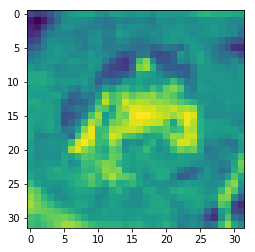

In [8]:
plt.imshow(x_train[0,:,:,0])

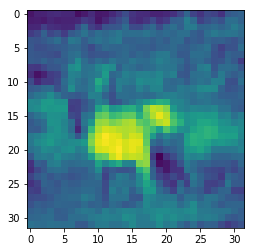

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

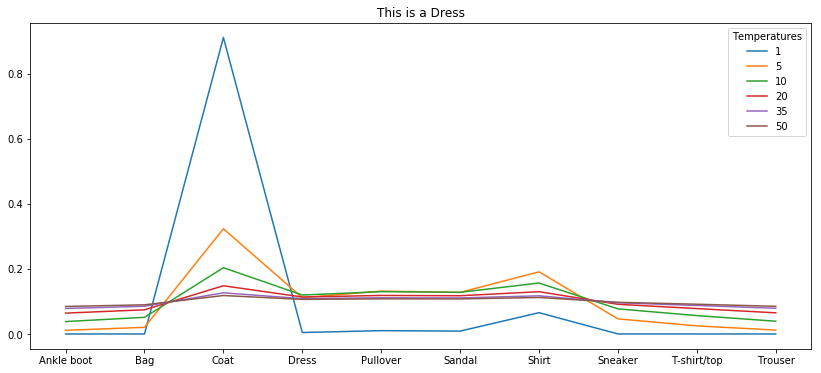

In [9]:
import copy
Teacher_logits = Model(Teacher.input,Teacher.layers[-2].output)

logits_plot = []

class_names = ["T-shirt/top",
               "Trouser",
               "Pullover",
               "Dress",
               "Coat",
               "Sandal",
               "Shirt",
               "Sneaker",
               "Bag",
               "Ankle boot"]

# Choose the item to visualize temperature
item_idx = 3

item_image = x_train[item_idx]

plt.imshow(item_image[:,:,0])

Temperatures = [1,5,10,20,35,50]


for Temperature in Temperatures :
  # Create temperature layer that produces logits with temperature
  T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)
  
  # Create a softmax layer
  Softmax_layer = Softmax()(T_layer)
  # Add the teacher T_layer to the whole model
  Teacher_logits_soften = Model(Teacher.input,Softmax_layer)
                             
  # Append for plotting
  logits_plot.append(Teacher_logits_soften.predict(np.array([item_image])))
  
  plt.figure(figsize=(14, 6))
for i in range(len(Temperatures)):
  sns.lineplot(class_names,logits_plot[i][0],legend="full")
  plt.title('This is a '+ class_names[item_idx])
  plt.legend(Temperatures,title="Temperatures")

# Create a teacher model that soften output
In this notebook, we use temperature 10.0

In [0]:
Temperature = 3.25
T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)
Softmax_layer = Activation('softmax')(T_layer)
Teacher_soften = Model(Teacher.input,Softmax_layer)

In [0]:
# Predict and convert to sparse categorical matrix
y_train_new = Teacher_soften.predict(x_train)
y_test_new = Teacher_soften.predict(x_test)

y_train_new = np.c_[to_categorical(y_train),y_train_new]
y_test_new = np.c_[to_categorical(y_test),y_test_new]

# Create a student model that produces with and without soften output

In [31]:
Student = Sequential() #a Must define the input shape in the first layer of the neural network
Student.add(Flatten(input_shape=(32,32,3)))
Student.add(Dense(64, activation='relu'))
Student.add(Dropout(0.5))
Student.add(Dense(10))
Student.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                196672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


In [0]:
student_logits = Student.layers[-1].output

# Compute softmax
probs = Activation("softmax")(student_logits)

# Compute softmax with softened logits
logits_T = Lambda(lambda x:x/Temperature)(student_logits)
probs_T = Activation("softmax")(logits_T)

CombinedLayers = concatenate([probs,probs_T])

StudentModel = Model(Student.input,CombinedLayers)

In [0]:
nb_classes=10
def KD_loss(y_true,y_pred,lambd=0.5,T=10.0):
  y_true,y_true_KD = y_true[:,:NUM_CLASSES],y_true[:,NUM_CLASSES:]
  y_pred,y_pred_KD = y_pred[:,:NUM_CLASSES],y_pred[:,NUM_CLASSES:]
  # Classic cross-entropy (without temperature)
  CE_loss = logloss(y_true,y_pred)
  # KL-Divergence loss for softened output (with temperature)
  KL_loss = T**2*KLD_Loss(y_true_KD,y_pred_KD)
  
  return lambd*CE_loss + (1-lambd)*KL_loss

def accuracy(y_true,y_pred):
  return categorical_accuracy(y_true,y_pred)
  

In [0]:
StudentModel.compile(optimizer='adam',loss=lambda y_true,y_pred: KD_loss(y_true, y_pred,lambd=0.45,T=Temperature),metrics=[accuracy])

In [30]:
StudentModel.fit(x_train,y_train_new,epochs=50,validation_split=0.15,batch_size=128)

Train on 42500 samples, validate on 7500 samples
Epoch 1/50
42500/42500 [==============================] - 2s 50us/sample - loss: 4.1227 - accuracy: 0.3040 - val_loss: 3.7351 - val_accuracy: 0.3433
Epoch 2/50
42500/42500 [==============================] - 2s 44us/sample - loss: 3.6639 - accuracy: 0.3654 - val_loss: 3.7239 - val_accuracy: 0.3172
Epoch 3/50
42500/42500 [==============================] - 2s 43us/sample - loss: 3.5115 - accuracy: 0.3838 - val_loss: 3.6574 - val_accuracy: 0.3424
Epoch 4/50
42500/42500 [==============================] - 2s 44us/sample - loss: 3.3966 - accuracy: 0.3939 - val_loss: 3.4471 - val_accuracy: 0.3727
Epoch 5/50
42500/42500 [==============================] - 2s 44us/sample - loss: 3.3275 - accuracy: 0.4039 - val_loss: 3.5554 - val_accuracy: 0.3605
Epoch 6/50
42500/42500 [==============================] - 2s 44us/sample - loss: 3.2623 - accuracy: 0.4092 - val_loss: 3.6559 - val_accuracy: 0.3484
Epoch 7/50
42500/42500 [==============================] -

In [17]:
StudentModel.predict(x_test)[3]

array([1.6898202e-11, 1.0000000e+00, 6.7737320e-14, 5.7937443e-11,
       1.4971269e-10, 9.0220249e-15, 3.5397504e-13, 9.9915626e-18,
       4.8287921e-15, 2.3620692e-17, 5.5596028e-02, 6.6414016e-01,
       3.2014191e-02, 6.2886246e-02, 6.9148950e-02, 2.6169175e-02,
       3.7770871e-02, 1.3250221e-02, 2.4583491e-02, 1.4440722e-02],
      dtype=float32)

In [18]:
y_test[3]

1

In [0]:
# Create a 

# Create a standalone student

In [32]:
AloneModel = Sequential() #a Must define the input shape in the first layer of the neural netAloneStudent = Sequential() #a Must define the input shape in the first layer of the neural network
AloneModel.add(Flatten(input_shape=(32,32,3)))
AloneModel.add(Dense(64, activation='relu'))
AloneModel.add(Dense(10,activation="softmax"))
AloneModel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                196672    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                650       
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


In [33]:
AloneModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

AloneModel.fit(x_train,y_train,epochs=50,validation_split=0.15,batch_size=128)


Train on 42500 samples, validate on 7500 samples
Epoch 1/50
42500/42500 [==============================] - 2s 41us/sample - loss: 2.0116 - acc: 0.2633 - val_loss: 1.8950 - val_acc: 0.3239
Epoch 2/50
42500/42500 [==============================] - 1s 34us/sample - loss: 1.8609 - acc: 0.3339 - val_loss: 1.9583 - val_acc: 0.2999
Epoch 3/50
42500/42500 [==============================] - 1s 33us/sample - loss: 1.8315 - acc: 0.3445 - val_loss: 1.8394 - val_acc: 0.3409
Epoch 4/50
42500/42500 [==============================] - 1s 33us/sample - loss: 1.8075 - acc: 0.3547 - val_loss: 1.8282 - val_acc: 0.3543
Epoch 5/50
42500/42500 [==============================] - 1s 34us/sample - loss: 1.7908 - acc: 0.3607 - val_loss: 1.8591 - val_acc: 0.3324
Epoch 6/50
42500/42500 [==============================] - 1s 33us/sample - loss: 1.7737 - acc: 0.3646 - val_loss: 1.7805 - val_acc: 0.3668
Epoch 7/50
42500/42500 [==============================] - 1s 33us/sample - loss: 1.7491 - acc: 0.3732 - val_loss: 1.7

In [36]:
AloneModel.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 61us/sample - loss: 1.8860 - acc: 0.3252


[1.8859866428375245, 0.3252]